In [1]:
import sys
import os
from tqdm import tqdm
import random
import numpy as np
import math
# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

sys.path.append(parent_dir)

#import simtrain
from simtrain.sim_models_new import User_simmulation_Model, Conditioned_User_simmulation_Model, Toy_intensity_Comparer, all_in_one_model

from simtrain import SETTINGS_POLIMI as SETTINGS
from simtrain import explore_models, process_dat
from simtrain.train import train_function_approx_multiple_variational

import simtrain.utils as utils
from simtrain.Dataset import CustomDataset, TimestepFrequencyDataset
from simtrain.train import train, train_with_negatives

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import ast

import paths
from os.path import join
import pytorch_warmup as warmup
from functools import partial
import torch.optim as optim
import matplotlib.pyplot as plt


In [2]:
#num_items = 7
#num_items_per_recom = 2
num_interaction_types = 2
recom_dim = 1
#num_users = 11
#min_inter = 2
#max_inter = 4
state_size = SETTINGS.STATE_SIZE
subset = 20 # make data smaller
experiment_name = "intensity"
num_negatives = 150
conditioned=False
kl_weight=.01
state_size

4

# Data

## old

In [3]:
#create dataset from processed data
if False:
    train_dat, stg = process_dat.load_dat(paths.cw_stages['output_new']['train'], new_data=True)

    print(stg)

    def convert_string_to_double_list(s):
        return ast.literal_eval(s)

    # Apply the custom function
    train_dat['item_ids'] = train_dat['item_ids'].apply(convert_string_to_double_list)
    train_dat['user_means'] = train_dat['user_means'].apply(convert_string_to_double_list)
    train_dat['user_vars_log'] = train_dat['user_vars_log'].apply(convert_string_to_double_list)
    train_dat['timestamps'] = train_dat['timestamps'].apply(convert_string_to_double_list)
    train_dat['interaction_types'] = train_dat['interaction_types'].apply(convert_string_to_double_list)

    print("len: ", len(train_dat))
    list_of_dicts = train_dat.to_dict(orient='records')
    list_of_dicts = list_of_dicts[:subset]
    train_dat.head()


In [4]:
#checkpoint = torch.load(join(paths.dat, SETTINGS.rootpaths['models'],
#                             experiment_name, "data.h5"))
#list_of_dicts = checkpoint['data']

In [5]:
'''
def adjust_hidden_dim(data_dict, state_size):
    # just to jumstart experiments should be deleted at the end
    for row in list_of_dicts:
        if row["user_means"] > state_size:
            row["user_means"] = row["user_means"][:state_size]
            row["user_vars_log"] = row["user_vars_log"][:state_size]
        elif row["user_means"] > state_size:


adjust_hidden_dim(list_of_dicts, state_size)
'''


'\ndef adjust_hidden_dim(data_dict, state_size):\n    # just to jumstart experiments should be deleted at the end\n    for row in list_of_dicts:\n        if row["user_means"] > state_size:\n            row["user_means"] = row["user_means"][:state_size]\n            row["user_vars_log"] = row["user_vars_log"][:state_size]\n        elif row["user_means"] > state_size:\n\n\nadjust_hidden_dim(list_of_dicts, state_size)\n'

In [6]:
#dataset = CustomDataset(list_of_dicts[:subset]) # [:30]

#dataloader = DataLoader(dataset, batch_size=1, shuffle=True)# can only do batchsize 1

In [7]:
def test_data(dataloader):
    smallest = float("inf")
    biggest = -1
    count_classes = [0 for _ in range(num_interaction_types)]
    for batch in dataloader:
        timestamps, items, labels, means, var, idx = batch
        last = timestamps[0]
        smallest = min(smallest, last)
        biggest = max(biggest, timestamps[-1])
        for i in range(1,len(timestamps)):
            if timestamps[i] <= last:
                print("error, current: ", timestamps[i], "\tlast", last)
        
        for i in range(num_interaction_types):
            for row in labels:
                row=torch.as_tensor(row)
                count = torch.sum(row == i)
                count_classes[i] += count

    smallest, biggest= int(smallest), float(biggest)
    print(smallest), print(biggest)
    for i in range(num_interaction_types):
        print(f"number of interactions of type {i} = {count_classes[i]}")
    return biggest

#max_time = test_data(dataloader)

In [8]:
'''
for batch in dataloader:
    timestamps, items, labels, means, var, idx = batch
    print('Timestamps:', timestamps#, "\n dtype: ", timestamps.dtype
          )
    print('item_recom:', items#, "\n dtype: ", items.dtype
          )
    print('Labels:', labels#, "\n dtype: ", labels.dtype
          )
    print('means:', means#, "\n dtype: ", means.dtype
          )
    print('log_var:', var#, "\n dtype: ", var.dtype
          )
    break
    '''

'\nfor batch in dataloader:\n    timestamps, items, labels, means, var, idx = batch\n    print(\'Timestamps:\', timestamps#, "\n dtype: ", timestamps.dtype\n          )\n    print(\'item_recom:\', items#, "\n dtype: ", items.dtype\n          )\n    print(\'Labels:\', labels#, "\n dtype: ", labels.dtype\n          )\n    print(\'means:\', means#, "\n dtype: ", means.dtype\n          )\n    print(\'log_var:\', var#, "\n dtype: ", var.dtype\n          )\n    break\n    '

## new

In [3]:
train_sorted = False
batchsize = 64  # needs to be 1 for ode
model_type = "simple"

In [4]:
#create dataset from processed data
if True:
    train_dat, stg = process_dat.load_dat(paths.cw_stages['output_new']['train'], new_data=True)

    print(stg)

    def convert_string_to_double_list(s):
        return ast.literal_eval(s)

    # Apply the custom function
    train_dat['item_ids'] = train_dat['item_ids'].apply(convert_string_to_double_list)
    train_dat['user_means'] = train_dat['user_means'].apply(convert_string_to_double_list)
    train_dat['user_vars_log'] = train_dat['user_vars_log'].apply(convert_string_to_double_list)
    train_dat['timestamps'] = train_dat['timestamps'].apply(convert_string_to_double_list)
    train_dat['interaction_types'] = train_dat['interaction_types'].apply(convert_string_to_double_list)

    print("len: ", len(train_dat))
    list_of_dicts = train_dat.to_dict(orient='records')
    list_of_dicts = list_of_dicts[:subset]
    train_dat.head()


{'NI': 14, 'NU': 328, 'T': '[9.708333333333334, 12.4375, 12.604166666666666, 13.395833333333334, 15.458333333333334, 15.979166666666666, 17.333333333333332, 18.6875, 20.58333333333333, 21.354166666666668, 21.375, 21.39583333333333, 21.416666666666668, 21.4375, 21.45833333333333, 21.479166666666668, 22.52083333333333, 24.39583333333333, 24.416666666666668, 24.4375, 24.45833333333333, 24.479166666666668, 24.5, 24.52083333333333, 25.479166666666668, 25.5, 25.52083333333333, 25.541666666666668, 25.58333333333333, 25.64583333333333, 29.33333333333333, 30.14583333333333, 30.58333333333333, 30.604166666666668, 30.625, 30.979166666666668, 32.0, 34.354166666666664, 36.66666666666666, 36.6875, 37.5625, 37.583333333333336, 38.583333333333336, 43.10416666666666, 43.333333333333336]', 'NS': 100, 'INF_TIME': 1000}
len:  328


In [5]:
# create dataset

dataloader_list = []
#steps_per_epoch = 0 

for user in list_of_dicts:
    timestamps = user["timestamps"]
    means, logvars = user["user_means"], user["user_vars_log"]
    dataset_for_user = TimestepFrequencyDataset(timestamps, num_random_points=num_negatives)

    dataloader = DataLoader(dataset_for_user, batch_size=batchsize, shuffle=not train_sorted
                        )
    dataloader_list.append([dataloader, means, logvars])
    #steps_per_epoch += len(dataset) // batchsize  
    #if len(dataset) % batchsize != 0:
    #    steps_per_epoch += 1
steps_per_epoch = 63# for 64b 80u, for 16b 20u: 221, for 64b u20: 63

In [6]:
path_list = []
for user in list_of_dicts:
    timestamps = user["timestamps"]
    means, logvars = user["user_means"], user["user_vars_log"]
    reaction_ratio = [np.mean(np.array(row)) for row in user["interaction_types"]]

    path_list.append([user["timestamps"], means, logvars, reaction_ratio])

# model

## Density

In [44]:
width=128
state_consistancy_training = True
intensity = {"model_hyp": {"layer_width": [width for _ in range(3)]}}
state_dict = {"model_hyp": {"layer_width": [width for _ in range(4)],
                            "noise": 0},
            }

timecheat = False
hyperparameter_dict = {"state_size": state_size, "state_model": state_dict, 
        "intensity_model": intensity, "state_model_type": model_type, # simple
        "time_embedding_size" :32, "max_freq": 70,
        }
model = Toy_intensity_Comparer(hyperparameter_dict)
print(model)


Toy_intensity_Comparer(
  (embed): SignWaveEmbedding()
  (user_state_model): Base_Model(
    (model): Sequential(
      (0): Linear(in_features=37, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): SiLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): SiLU()
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): SiLU()
      (8): Linear(in_features=128, out_features=4, bias=True)
    )
  )
  (intensity_model): User_State_Intensity_Model_simple(
    (model): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): SiLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): SiLU()
      (6): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)


In [47]:

num_epochs = 1500
warmup_period = steps_per_epoch*20
num_steps = num_epochs*steps_per_epoch - warmup_period
num_iter_til_first_restart = (num_steps + 11)//10  
# restarts seem to ne be great most of the time here
user_lr = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

optimizer = optim.AdamW(model.parameters(), lr=user_lr,
                        weight_decay=1e-5)
lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=num_iter_til_first_restart, T_mult=2, eta_min=5e-6)

warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)


Using device: cpu


In [48]:
from simtrain.utils import weighted_mse_loss
from simtrain.train import train_density_multiple_variational

loss = partial(weighted_mse_loss, weight_pos=10)
loss_func_kl=partial(utils.kl_divergence, mu2=0, sigma2=0.01)

In [50]:
results =train_density_multiple_variational(model, dataloader_list, criterion=weighted_mse_loss, 
            state_size=state_size, user_lr_decay=0.9950,
            state_consistancy_training=state_consistancy_training, consistancy_weight=.5,
            optimizer=optimizer, num_epochs=num_epochs, warmup_scheduler=warmup_scheduler,
            loss_func_kl=loss_func_kl, kl_weight=.01, user_lr=.02, device=device, 
            loss_print_interval=25, warmup_period=warmup_period, lr_scheduler=lr_scheduler)


  0%|          | 1/1500 [00:00<16:00,  1.56it/s]

epoch: 1 loss_sum_all: 2445.7813, loss_sum_freq: 2431.855122708035, loss_sum_kl: 13.338012797757983, loss_state_consistancy: 0.5881734198192134


  2%|▏         | 26/1500 [00:22<20:14,  1.21it/s]

epoch: 26 loss_sum_all: 1454.2750, loss_sum_freq: 1407.749483011663, loss_sum_kl: 44.02124209329486, loss_state_consistancy: 2.504263319540769


  3%|▎         | 51/1500 [00:41<15:23,  1.57it/s]

epoch: 51 loss_sum_all: 1389.9888, loss_sum_freq: 1313.3131197534967, loss_sum_kl: 69.84337016195059, loss_state_consistancy: 6.832321306457743


  5%|▌         | 76/1500 [01:01<17:01,  1.39it/s]

epoch: 76 loss_sum_all: 641.0787, loss_sum_freq: 605.7810938237235, loss_sum_kl: 33.68219915404916, loss_state_consistancy: 1.6153677003458142


  7%|▋         | 101/1500 [01:22<17:10,  1.36it/s]

epoch: 101 loss_sum_all: 705.5490, loss_sum_freq: 678.8881359564257, loss_sum_kl: 25.172414664179087, loss_state_consistancy: 1.4884269861504436


  8%|▊         | 126/1500 [01:44<17:30,  1.31it/s]

epoch: 126 loss_sum_all: 1145.4987, loss_sum_freq: 1106.8846591198817, loss_sum_kl: 34.99304570257664, loss_state_consistancy: 3.6210373336216435


 10%|█         | 151/1500 [02:05<14:00,  1.61it/s]

epoch: 151 loss_sum_all: 516.8477, loss_sum_freq: 493.9924956111936, loss_sum_kl: 20.810776364058256, loss_state_consistancy: 2.044458425603807


 12%|█▏        | 176/1500 [02:23<14:21,  1.54it/s]

epoch: 176 loss_sum_all: 866.2503, loss_sum_freq: 847.4886450059712, loss_sum_kl: 17.088805744424462, loss_state_consistancy: 1.6728491028770804


 13%|█▎        | 201/1500 [02:39<12:38,  1.71it/s]

epoch: 201 loss_sum_all: 722.9950, loss_sum_freq: 713.3478768334026, loss_sum_kl: 9.053054202347994, loss_state_consistancy: 0.594082597293891


 15%|█▌        | 226/1500 [02:58<12:46,  1.66it/s]

epoch: 226 loss_sum_all: 436.9821, loss_sum_freq: 421.90133352614066, loss_sum_kl: 13.94283401593566, loss_state_consistancy: 1.1379015678539872


 17%|█▋        | 251/1500 [03:15<12:05,  1.72it/s]

epoch: 251 loss_sum_all: 557.1498, loss_sum_freq: 540.5286886460199, loss_sum_kl: 14.24772997573018, loss_state_consistancy: 2.3733709952794015


 18%|█▊        | 276/1500 [03:33<16:53,  1.21it/s]

epoch: 276 loss_sum_all: 527.1516, loss_sum_freq: 500.73750939348247, loss_sum_kl: 22.152739986777306, loss_state_consistancy: 4.2613645867677405


 20%|██        | 301/1500 [03:48<10:40,  1.87it/s]

epoch: 301 loss_sum_all: 234.5852, loss_sum_freq: 225.89639504969497, loss_sum_kl: 8.131787925958633, loss_state_consistancy: 0.5570374348026235


 22%|██▏       | 326/1500 [04:01<09:59,  1.96it/s]

epoch: 326 loss_sum_all: 260.2206, loss_sum_freq: 246.8532299727285, loss_sum_kl: 11.230092234909534, loss_state_consistancy: 2.137305704294704


 23%|██▎       | 351/1500 [04:15<10:54,  1.76it/s]

epoch: 351 loss_sum_all: 256.7716, loss_sum_freq: 246.5227879388476, loss_sum_kl: 8.959329664707184, loss_state_consistancy: 1.2894983367295936


 25%|██▌       | 376/1500 [04:29<09:40,  1.94it/s]

epoch: 376 loss_sum_all: 368.6535, loss_sum_freq: 358.9675235154682, loss_sum_kl: 8.166764415800571, loss_state_consistancy: 1.5192170246737078


 27%|██▋       | 401/1500 [04:42<09:42,  1.89it/s]

epoch: 401 loss_sum_all: 238.8707, loss_sum_freq: 228.39369906705906, loss_sum_kl: 8.71887593343854, loss_state_consistancy: 1.7581428794655949


 28%|██▊       | 426/1500 [04:57<09:17,  1.92it/s]

epoch: 426 loss_sum_all: 173.0478, loss_sum_freq: 164.14028640267577, loss_sum_kl: 7.419437255710363, loss_state_consistancy: 1.4880906415637583


 30%|███       | 451/1500 [05:11<09:50,  1.78it/s]

epoch: 451 loss_sum_all: 364.9048, loss_sum_freq: 360.34777020854585, loss_sum_kl: 4.300454765558243, loss_state_consistancy: 0.25659982400247827


 32%|███▏      | 476/1500 [05:27<12:43,  1.34it/s]

epoch: 476 loss_sum_all: 148.9290, loss_sum_freq: 138.65606772901083, loss_sum_kl: 8.198911666870117, loss_state_consistancy: 2.0740289613604546


 33%|███▎      | 501/1500 [05:45<09:41,  1.72it/s]

epoch: 501 loss_sum_all: 150.0095, loss_sum_freq: 140.9500138569274, loss_sum_kl: 7.944989118725061, loss_state_consistancy: 1.1144719991716556


 35%|███▌      | 526/1500 [06:01<11:26,  1.42it/s]

epoch: 526 loss_sum_all: 174.4006, loss_sum_freq: 166.49636450183868, loss_sum_kl: 6.403495043516159, loss_state_consistancy: 1.5007760158623569


 37%|███▋      | 551/1500 [06:17<07:58,  1.98it/s]

epoch: 551 loss_sum_all: 62.9973, loss_sum_freq: 55.57537691677862, loss_sum_kl: 6.572943825274706, loss_state_consistancy: 0.8489518659189343


 38%|███▊      | 576/1500 [06:32<08:25,  1.83it/s]

epoch: 576 loss_sum_all: 120.7289, loss_sum_freq: 114.75551220579837, loss_sum_kl: 5.446814194321632, loss_state_consistancy: 0.5265483080875129


 40%|████      | 601/1500 [06:45<07:47,  1.92it/s]

epoch: 601 loss_sum_all: 46.2174, loss_sum_freq: 37.59766146599861, loss_sum_kl: 7.0777611918747425, loss_state_consistancy: 1.5419809909071773


 42%|████▏     | 626/1500 [07:08<11:16,  1.29it/s]

epoch: 626 loss_sum_all: 101.9545, loss_sum_freq: 97.41351585568509, loss_sum_kl: 4.301677606999874, loss_state_consistancy: 0.2392877775710076


 43%|████▎     | 651/1500 [07:28<11:09,  1.27it/s]

epoch: 651 loss_sum_all: 40.1813, loss_sum_freq: 33.52095933279733, loss_sum_kl: 5.820070002228022, loss_state_consistancy: 0.8402884530369192


 45%|████▌     | 676/1500 [07:48<15:24,  1.12s/it]

epoch: 676 loss_sum_all: 32.4962, loss_sum_freq: 25.590860234915773, loss_sum_kl: 5.987780466675758, loss_state_consistancy: 0.9175327232806012


 47%|████▋     | 701/1500 [08:05<09:16,  1.44it/s]

epoch: 701 loss_sum_all: 63.7739, loss_sum_freq: 56.74662734780213, loss_sum_kl: 6.248792443424463, loss_state_consistancy: 0.7785292190965265


 48%|████▊     | 726/1500 [08:26<08:47,  1.47it/s]

epoch: 726 loss_sum_all: 60.8808, loss_sum_freq: 53.694635385471315, loss_sum_kl: 6.106617696583271, loss_state_consistancy: 1.0795474840560928


 50%|█████     | 751/1500 [08:46<09:44,  1.28it/s]

epoch: 751 loss_sum_all: 1798.7358, loss_sum_freq: 1789.1871427745111, loss_sum_kl: 7.299873773008585, loss_state_consistancy: 2.248764493037015


 52%|█████▏    | 776/1500 [09:04<07:46,  1.55it/s]

epoch: 776 loss_sum_all: 1425.8986, loss_sum_freq: 1414.2895605751178, loss_sum_kl: 9.433044459670782, loss_state_consistancy: 2.1759570826543495


 53%|█████▎    | 801/1500 [09:22<08:49,  1.32it/s]

epoch: 801 loss_sum_all: 1300.1422, loss_sum_freq: 1285.9628760300693, loss_sum_kl: 11.143456097692251, loss_state_consistancy: 3.0358201793860644


 55%|█████▌    | 826/1500 [09:41<09:17,  1.21it/s]

epoch: 826 loss_sum_all: 430.1401, loss_sum_freq: 417.04135534726083, loss_sum_kl: 10.939070601016283, loss_state_consistancy: 2.1596683218958788


 57%|█████▋    | 851/1500 [10:02<07:45,  1.39it/s]

epoch: 851 loss_sum_all: 352.4603, loss_sum_freq: 344.4068189300171, loss_sum_kl: 7.273000944405794, loss_state_consistancy: 0.7805233887629583


 58%|█████▊    | 876/1500 [10:21<07:32,  1.38it/s]

epoch: 876 loss_sum_all: 637.4509, loss_sum_freq: 623.4600318804296, loss_sum_kl: 10.483041603118181, loss_state_consistancy: 3.507871208479628


 59%|█████▊    | 881/1500 [10:26<07:19,  1.41it/s]


KeyboardInterrupt: 

In [ ]:
cycycyc

NameError: name 'cycycyc' is not defined

### visualization

variance of states:  tensor(0.0385)
area: 17.822305755615233


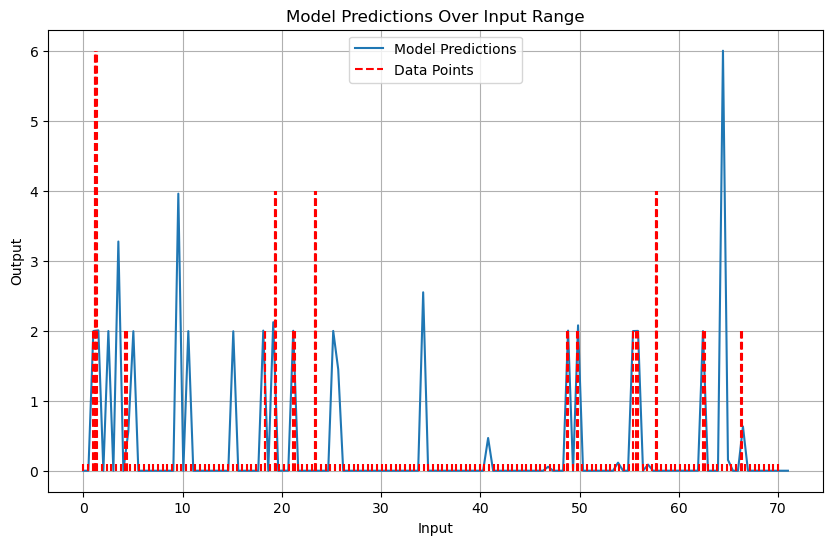

In [43]:
selected_user = 14
dataloader, variational_means, variational_logvar = dataloader_list[selected_user]
dataset = dataloader.dataset
x_range = np.linspace(0, 71, 71*2)  # Adjust the range as needed
x_range_tensor = torch.tensor(x_range, dtype=torch.float32).unsqueeze(1)
model.eval()
with torch.no_grad():
    if model_type == "ode":
        raise NotImplementedError
        state = torch.zeros((1, state_size))

        predictions = []
        for el in x_range:
            out = model(state, el)
            predictions.append(out[0])
    else:
        state = torch.tensor(variational_means).repeat(len(x_range),1)
        predictions, states = model(state, x_range_tensor, return_new_state=True)
        predictions = predictions.numpy()
        print("variance of states: ", torch.var(states))

print(f"area: {np.sum(predictions)*(72/200)}")
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_range, predictions, label='Model Predictions')

for i in range(len(dataset)):
    sample = dataset[i]
    x_pos= sample['timestep'].item()
    height = torch.where(sample['frequency']>0, sample['frequency'], .1).item()
    plt.plot([x_pos, x_pos], [0, height], linestyle='--', color='red')

plt.plot([0, 0], [0, 0], color='red', linestyle='--', alpha=1.0, label='Data Points')

#plt.scatter(x_train.numpy(), y_train.numpy(), color='red', label='Training Data')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Model Predictions Over Input Range')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
sdfsd  # 30 users below

area: 64.883671875


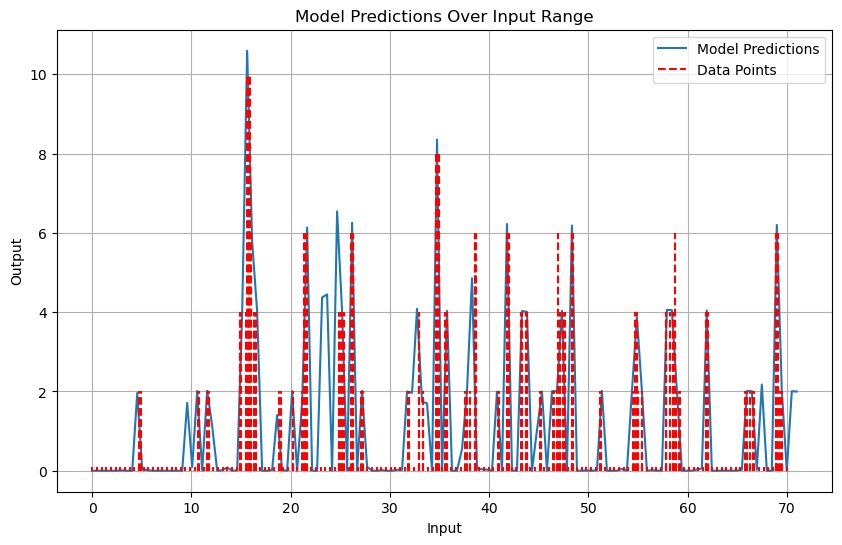

In [ ]:
selected_user = 10
dataloader, variational_means, variational_logvar = dataloader_list[selected_user]
dataset = dataloader.dataset
x_range = np.linspace(0, 71, 71*2)  # Adjust the range as needed
x_range_tensor = torch.tensor(x_range, dtype=torch.float32).unsqueeze(1)
model.eval()
with torch.no_grad():
    if model_type == "ode":
        raise NotImplementedError
        state = torch.zeros((1, state_size))

        predictions = []
        for el in x_range:
            out = model(state, el)
            predictions.append(out[0])
    else:
        state = torch.tensor(variational_means).repeat(len(x_range),1)
        predictions = model(state, x_range_tensor).numpy()

print(f"area: {np.sum(predictions)*(72/200)}")
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_range, predictions, label='Model Predictions')

for i in range(len(dataset)):
    sample = dataset[i]
    x_pos= sample['timestep'].item()
    height = torch.where(sample['frequency']>0, sample['frequency'], .1).item()
    plt.plot([x_pos, x_pos], [0, height], linestyle='--', color='red')

plt.plot([0, 0], [0, 0], color='red', linestyle='--', alpha=1.0, label='Data Points')

#plt.scatter(x_train.numpy(), y_train.numpy(), color='red', label='Training Data')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Model Predictions Over Input Range')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
assdad

area: 8.561624908447266


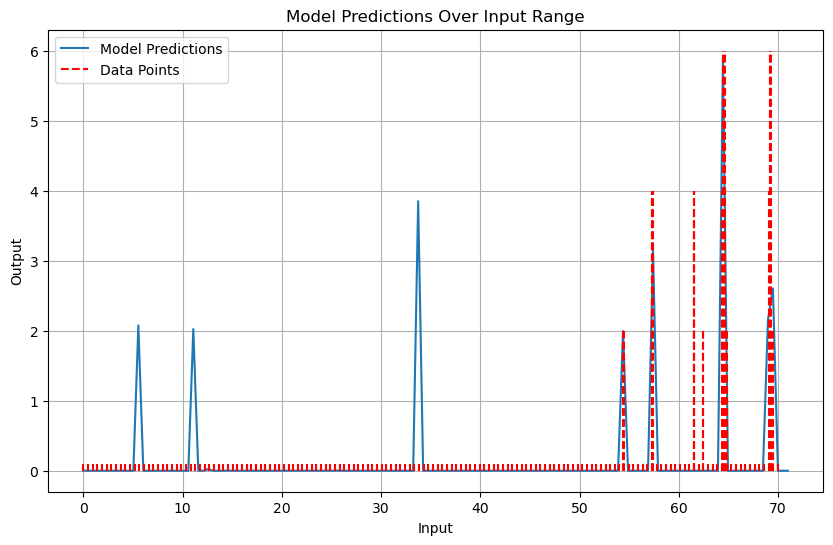

In [ ]:
selected_user = 1
dataloader, variational_means, variational_logvar = dataloader_list[selected_user]
dataset = dataloader.dataset
x_range = np.linspace(0, 71, 71*2)  # Adjust the range as needed
x_range_tensor = torch.tensor(x_range, dtype=torch.float32).unsqueeze(1)
model.eval()
with torch.no_grad():
    if model_type == "ode":
        raise NotImplementedError
        state = torch.zeros((1, state_size))

        predictions = []
        for el in x_range:
            out = model(state, el)
            predictions.append(out[0])
    else:
        state = torch.tensor(variational_means).repeat(len(x_range),1)
        predictions = model(state, x_range_tensor).numpy()

print(f"area: {np.sum(predictions)*(72/200)}")
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_range, predictions, label='Model Predictions')

for i in range(len(dataset)):
    sample = dataset[i]
    x_pos= sample['timestep'].item()
    height = torch.where(sample['frequency']>0, sample['frequency'], .1).item()
    plt.plot([x_pos, x_pos], [0, height], linestyle='--', color='red')

plt.plot([0, 0], [0, 0], color='red', linestyle='--', alpha=1.0, label='Data Points')

#plt.scatter(x_train.numpy(), y_train.numpy(), color='red', label='Training Data')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Model Predictions Over Input Range')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
scdc

## function Approx. sampling

In [7]:
width=64
use_jump = True
user_state_dict = {"model_hyp": {"layer_width": [width for _ in range(4)]}}
time_dict = {"model_hyp": {"layer_width": [width for _ in range(3)]}
            }
jump_dict= {"model_hyp": {"layer_width": [8, 8]}
            }


timecheat = False
hyperparameter_dict = {"state_size": state_size, "time_model": time_dict, 
                           "state_model": user_state_dict,
                           "jump_model": jump_dict}
train_model = all_in_one_model(hyperparameter_dict, timecheat=timecheat)

In [11]:
steps_per_epoch = 20

num_epochs = 1000
warmup_period = steps_per_epoch * 10
num_steps = num_epochs*steps_per_epoch - warmup_period
num_iter_til_first_restart = (num_steps + 1)
user_lr = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

optimizer = optim.AdamW(train_model.parameters(), lr=user_lr,
                        weight_decay=1e-7)
lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=num_iter_til_first_restart, T_mult=1, eta_min=1e-7)

warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)


Using device: cpu


In [12]:
from simtrain.utils import weighted_mse_loss

loss_func_kl=partial(utils.kl_divergence, mu2=0, sigma2=0.01)

In [13]:
train_function_approx_multiple_variational(train_model, path_list, scoring_func=utils.energy_score_loss,
            device=device, user_lr=0.01, user_lr_decay=0.995,
            loss_func_kl=loss_func_kl, kl_weight=.01, 
            state_size=state_size, warmup_scheduler=warmup_scheduler, lr_scheduler=lr_scheduler,
            optimizer=optimizer, num_epochs=num_epochs, num_tries=30, timecheat=timecheat, 
            loss_print_interval=25, include_jump=use_jump,
            warmup_period=warmup_period)


  0%|          | 1/1000 [00:01<33:04,  1.99s/it]

epoch: 1 loss_sum_all: 833.6502, loss_sum_freq: 776.7549033164978, loss_sum_kl: 56.89532133936882


  3%|▎         | 26/1000 [01:01<40:32,  2.50s/it]

epoch: 26 loss_sum_all: 900.1729, loss_sum_freq: 842.0193314552307, loss_sum_kl: 58.15360262989998


  5%|▌         | 51/1000 [02:11<42:47,  2.71s/it]

epoch: 51 loss_sum_all: 845.4137, loss_sum_freq: 783.0162003040314, loss_sum_kl: 62.39751723408699


  8%|▊         | 76/1000 [03:13<35:39,  2.32s/it]

epoch: 76 loss_sum_all: 825.2867, loss_sum_freq: 769.9680051803589, loss_sum_kl: 55.318652391433716


 10%|█         | 101/1000 [04:20<39:53,  2.66s/it]

epoch: 101 loss_sum_all: 854.5796, loss_sum_freq: 800.3116111755371, loss_sum_kl: 54.26796083152294


 13%|█▎        | 126/1000 [05:21<35:36,  2.44s/it]

epoch: 126 loss_sum_all: 782.2904, loss_sum_freq: 727.8988027572632, loss_sum_kl: 54.39162455499172


 15%|█▌        | 151/1000 [06:23<33:36,  2.38s/it]

epoch: 151 loss_sum_all: 800.2413, loss_sum_freq: 749.5547170639038, loss_sum_kl: 50.686545699834824


 18%|█▊        | 176/1000 [07:23<33:00,  2.40s/it]

epoch: 176 loss_sum_all: 787.5231, loss_sum_freq: 735.400363445282, loss_sum_kl: 52.12277068942785


 20%|██        | 201/1000 [08:25<30:29,  2.29s/it]

epoch: 201 loss_sum_all: 690.7983, loss_sum_freq: 642.3527522087097, loss_sum_kl: 48.44557352364063


 23%|██▎       | 226/1000 [09:21<32:09,  2.49s/it]

epoch: 226 loss_sum_all: 673.6491, loss_sum_freq: 628.3655896186829, loss_sum_kl: 45.28347186744213


 25%|██▌       | 251/1000 [10:22<29:57,  2.40s/it]

epoch: 251 loss_sum_all: 641.0681, loss_sum_freq: 596.3371806144714, loss_sum_kl: 44.73097538948059


 28%|██▊       | 276/1000 [11:23<26:56,  2.23s/it]

epoch: 276 loss_sum_all: 679.0325, loss_sum_freq: 634.457775592804, loss_sum_kl: 44.5747192800045


 30%|███       | 301/1000 [12:26<29:30,  2.53s/it]

epoch: 301 loss_sum_all: 579.7292, loss_sum_freq: 537.22203373909, loss_sum_kl: 42.507130831480026


 33%|███▎      | 326/1000 [13:31<31:52,  2.84s/it]

epoch: 326 loss_sum_all: 561.5845, loss_sum_freq: 519.6119940280914, loss_sum_kl: 41.97248174250126


 35%|███▌      | 351/1000 [14:36<26:56,  2.49s/it]

epoch: 351 loss_sum_all: 571.4883, loss_sum_freq: 530.7597224712372, loss_sum_kl: 40.72855480015278


 38%|███▊      | 376/1000 [15:38<24:19,  2.34s/it]

epoch: 376 loss_sum_all: 465.0180, loss_sum_freq: 424.6342649459839, loss_sum_kl: 40.3836874589324


 40%|████      | 401/1000 [16:32<23:27,  2.35s/it]

epoch: 401 loss_sum_all: 544.2564, loss_sum_freq: 503.86315631866455, loss_sum_kl: 40.393281273543835


 43%|████▎     | 426/1000 [17:33<20:56,  2.19s/it]

epoch: 426 loss_sum_all: 479.3872, loss_sum_freq: 439.0035049915314, loss_sum_kl: 40.38368234783411


 45%|████▌     | 451/1000 [18:38<21:13,  2.32s/it]

epoch: 451 loss_sum_all: 460.9132, loss_sum_freq: 421.69350230693817, loss_sum_kl: 39.21972829848528


 48%|████▊     | 476/1000 [19:36<19:24,  2.22s/it]

epoch: 476 loss_sum_all: 419.5591, loss_sum_freq: 380.0238633155823, loss_sum_kl: 39.53519283980131


 50%|█████     | 501/1000 [20:35<17:57,  2.16s/it]

epoch: 501 loss_sum_all: 388.4203, loss_sum_freq: 348.5570869445801, loss_sum_kl: 39.863222666084766


 53%|█████▎    | 526/1000 [21:36<18:44,  2.37s/it]

epoch: 526 loss_sum_all: 410.4239, loss_sum_freq: 370.9310233592987, loss_sum_kl: 39.492830753326416


 55%|█████▌    | 551/1000 [22:36<17:52,  2.39s/it]

epoch: 551 loss_sum_all: 418.5088, loss_sum_freq: 379.4432690143585, loss_sum_kl: 39.06553886830807


 58%|█████▊    | 576/1000 [23:36<15:59,  2.26s/it]

epoch: 576 loss_sum_all: 375.6515, loss_sum_freq: 336.94554352760315, loss_sum_kl: 38.70592441782355


 60%|██████    | 601/1000 [24:31<13:52,  2.09s/it]

epoch: 601 loss_sum_all: 356.8473, loss_sum_freq: 318.80774092674255, loss_sum_kl: 38.039557337760925


 63%|██████▎   | 626/1000 [25:24<12:58,  2.08s/it]

epoch: 626 loss_sum_all: 331.4579, loss_sum_freq: 293.7961595058441, loss_sum_kl: 37.66176003590226


 65%|██████▌   | 651/1000 [26:17<12:27,  2.14s/it]

epoch: 651 loss_sum_all: 334.3094, loss_sum_freq: 296.86552691459656, loss_sum_kl: 37.443879544734955


 68%|██████▊   | 676/1000 [27:11<11:30,  2.13s/it]

epoch: 676 loss_sum_all: 340.4726, loss_sum_freq: 303.4051558971405, loss_sum_kl: 37.067423053085804


 70%|███████   | 701/1000 [28:04<11:49,  2.37s/it]

epoch: 701 loss_sum_all: 304.5540, loss_sum_freq: 267.6283974647522, loss_sum_kl: 36.92561923339963


 73%|███████▎  | 726/1000 [29:07<10:43,  2.35s/it]

epoch: 726 loss_sum_all: 286.8150, loss_sum_freq: 250.18662536144257, loss_sum_kl: 36.62837338447571


 75%|███████▌  | 751/1000 [30:08<10:34,  2.55s/it]

epoch: 751 loss_sum_all: 300.1567, loss_sum_freq: 263.7734293937683, loss_sum_kl: 36.38328294828534


 78%|███████▊  | 776/1000 [31:07<08:18,  2.22s/it]

epoch: 776 loss_sum_all: 277.2284, loss_sum_freq: 241.05287408828735, loss_sum_kl: 36.17552159354091


 80%|████████  | 801/1000 [32:05<08:09,  2.46s/it]

epoch: 801 loss_sum_all: 273.7617, loss_sum_freq: 237.83993768692017, loss_sum_kl: 35.92176979780197


 83%|████████▎ | 826/1000 [33:05<06:11,  2.14s/it]

epoch: 826 loss_sum_all: 257.6863, loss_sum_freq: 221.7899227142334, loss_sum_kl: 35.89641534537077


 85%|████████▌ | 851/1000 [34:02<05:42,  2.30s/it]

epoch: 851 loss_sum_all: 256.1908, loss_sum_freq: 220.386576294899, loss_sum_kl: 35.804212275892496


 88%|████████▊ | 876/1000 [35:04<04:46,  2.31s/it]

epoch: 876 loss_sum_all: 254.4573, loss_sum_freq: 218.82707685232162, loss_sum_kl: 35.63024093210697


 90%|█████████ | 901/1000 [36:02<03:45,  2.28s/it]

epoch: 901 loss_sum_all: 246.1324, loss_sum_freq: 210.43478560447693, loss_sum_kl: 35.697597328573465


 93%|█████████▎| 926/1000 [37:00<02:42,  2.20s/it]

epoch: 926 loss_sum_all: 250.7919, loss_sum_freq: 215.28061187267303, loss_sum_kl: 35.51130275800824


 95%|█████████▌| 951/1000 [4:13:15<03:23,  4.15s/it]     

epoch: 951 loss_sum_all: 239.5402, loss_sum_freq: 204.0517876148224, loss_sum_kl: 35.48840384185314


 98%|█████████▊| 976/1000 [4:14:23<00:59,  2.46s/it]

epoch: 976 loss_sum_all: 252.1721, loss_sum_freq: 216.7599036693573, loss_sum_kl: 35.41222697496414


100%|██████████| 1000/1000 [4:15:26<00:00, 15.33s/it]

epoch: 1000 loss_sum_all: 246.9552, loss_sum_freq: 211.55171072483063, loss_sum_kl: 35.40353564918041


[(0, 833.6502242088318, 776.7549033164978, 56.89532133936882),
 (25, 900.1729288101196, 842.0193314552307, 58.15360262989998),
 (50, 845.4137110710144, 783.0162003040314, 62.39751723408699),
 (75, 825.2866563796997, 769.9680051803589, 55.318652391433716),
 (100, 854.5795745849609, 800.3116111755371, 54.26796083152294),
 (125, 782.2904214859009, 727.8988027572632, 54.39162455499172),
 (150, 800.2412619590759, 749.5547170639038, 50.686545699834824),
 (175, 787.5231351852417, 735.400363445282, 52.12277068942785),
 (200, 690.7983326911926, 642.3527522087097, 48.44557352364063),
 (225, 673.6490631103516, 628.3655896186829, 45.28347186744213),
 (250, 641.0681495666504, 596.3371806144714, 44.73097538948059),
 (275, 679.0325016975403, 634.457775592804, 44.5747192800045),
 (300, 579.7291560173035, 537.22203373909, 42.507130831480026),
 (325, 561.5844693183899, 519.6119940280914, 41.97248174250126),
 (350, 571.4882850646973, 530.7597224712372, 40.72855480015278),
 (375, 465.01795196533203, 424.6

### visualization

In [56]:
def simulate_single_forced_function_approx(model, user_data, state_size, use_jump=False,
                                           timecheat=False, num_tries=20, state=None):
    
    last_t = 0
    if (state is None):
        state = torch.zeros((1, state_size))
    path, variational_means, variational_logvar, reaction_ratio = user_data
    results = []
    with torch.no_grad():
        for interaction_id in range(len(path)):
            timestep = path[interaction_id]
            current_pred = []
            for _ in range(num_tries):
                if timecheat:
                    next_time=model.get_time(state, last_t)
                else:
                    next_time=model.get_time(state)
                #print(f"next_time: {next_time}, next_state: {next_state}")
                current_pred.append(last_t + next_time[0])
            current_pred = torch.stack(current_pred)
            results.append(torch.mean(current_pred))
            last_t = timestep
            state = model.get_new_state(state, torch.tensor([[timestep]]))
            if use_jump:
                    reactions_ratio_tensor = torch.tensor(reaction_ratio[interaction_id], dtype=torch.float32).view(1,-1)
                    state = model.jump(state, reactions_ratio_tensor)
    
    return results

def simulate_single_function_approx(model, state_size, num_events=10, 
            timecheat=False, num_tries=20, state=None, use_jump=False,):
    if use_jump:
        raise NotImplementedError# what should this do?
    
    last_t = 0
    if (state is None):
        state = torch.zeros((1, state_size))
    results = []
    with torch.no_grad():
        for _ in range(num_events):
            current_pred = []
            for _ in range(num_tries):
                if timecheat:
                    next_time=model.get_time(state, last_t)
                else:
                    next_time=model.get_time(state)
                
                current_pred.append(last_t + next_time[0])
            current_pred = torch.stack(current_pred)
            selected = torch.mean(current_pred)
            results.append(selected)
            last_t = selected
            state = model.get_new_state(state, torch.tensor([[selected]]))
    
    return results

In [103]:
user_id = 8
sample_path = path_list[user_id]
state = torch.tensor([sample_path[1]])
len(sample_path[0]), state

(12, tensor([[-0.0044, -0.1319,  0.0402, -0.0650]]))

In [110]:
# simpler nn
simulate_single_partial_forced_function_approx = partial(
    simulate_single_forced_function_approx, user_data=sample_path,state=state,
                              num_tries=1, timecheat=timecheat, state_size=state_size,
                              use_jump=use_jump)
simulate_single_partial_function_approx = partial(
    simulate_single_function_approx, num_events =len(sample_path), state=state,
                              num_tries=200, timecheat=timecheat, state_size=state_size,
                              use_jump=False)

In [111]:
# intensity
example_out_forced = simulate_single_partial_forced_function_approx(train_model)
example_out = simulate_single_partial_function_approx(train_model)
example_out_forced

[tensor(4.5907),
 tensor(18.7098),
 tensor(19.2759),
 tensor(20.0619),
 tensor(20.4208),
 tensor(22.1899),
 tensor(22.5484),
 tensor(22.7632),
 tensor(28.5034),
 tensor(28.4951),
 tensor(29.3552),
 tensor(29.1520)]

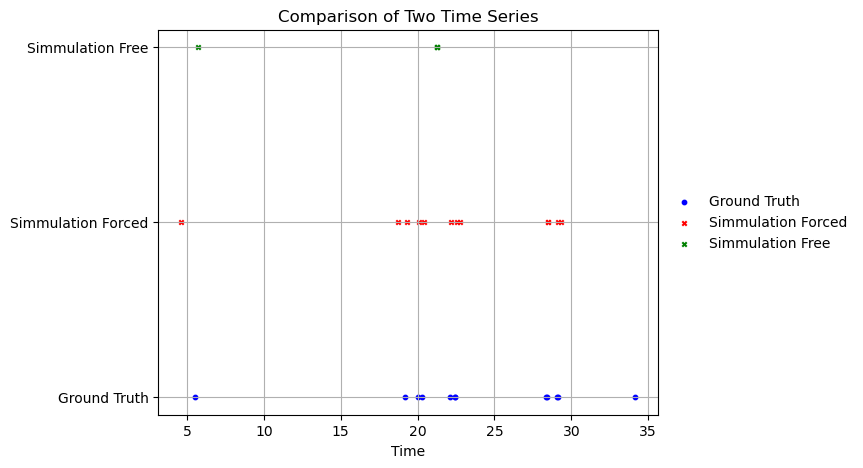

In [112]:
time_series_1 = sample_path[0] # Timestamps for the first time series
time_series_2 = torch.clamp(torch.as_tensor(example_out_forced),0,70).detach().numpy()  # Timestamps for the second time series
time_series_3 = torch.clamp(torch.as_tensor(example_out), 0, 70).detach().numpy()  # Timestamps for the second time series


# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the first time series
ax.scatter(time_series_1, [1] * len(time_series_1), color='blue', label='Ground Truth', s=10, marker='o')

# Plot the second time series
ax.scatter(time_series_2, [2] * len(time_series_2), color='red', label='Simmulation Forced', s=10, marker='x')

ax.scatter(time_series_3, [3] * len(time_series_3), color='green', label='Simmulation Free', s=10, marker='x')


# Add labels, legend, and grid
ax.set_xlabel('Time')
ax.set_yticks([1, 2, 3])
ax.set_yticklabels(['Ground Truth', 'Simmulation Forced', "Simmulation Free"])
ax.set_title('Comparison of Two Time Series')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

# Adjust subplot parameters to make room for the legend
plt.subplots_adjust(right=0.75)
ax.grid(True)

# Display the plot
plt.show()


# Combined Models old

In [ ]:
# parameter dicts
width= 32
user_state_dict = {"model_hyp": {"layer_width": [width, width, width]}}
intensity_state_dict = {"model_hyp": {"user_model_hyp": {"layer_width": [width, width],
                                        "noise": 0},
                        "global_model_hyp": {"layer_width": [width, 3]}}
                            }
interaction_state_dict = {"model_hyp": {"layer_width": [width, width ,width]}
                            }
jump_state_dict = {"model_hyp": {"layer_width": [width, width]}
                        }

In [ ]:
import torch.optim as optim

hyperparameter_dict = {"state_size": state_size, "state_model": user_state_dict, "num_interaction_outcomes": num_interaction_types,
        "intensity_model": intensity_state_dict,# "num_recom" : num_items_per_recom,
        "recom_dim":recom_dim, "interaction_model": interaction_state_dict,
        "jump_model": jump_state_dict, "user_params_size": state_size,
        "noise": .01}
model = User_simmulation_Model(hyperparameter_dict)
#model = Conditioned_User_simmulation_Model(hyperparameter_dict)

In [ ]:
# load model
path = join(paths.dat, SETTINGS.rootpaths['models'],
                 experiment_name, "user_model.h5")
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
num_epochs = 10
warmup_period = len(dataset)
num_steps = num_epochs*len(dataset) -warmup_period
num_iter_til_first_restart = num_steps//2
user_lr = 0.01

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

optimizer = optim.AdamW(model.parameters(), lr=0.01,
                        weight_decay=1e-7)
lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=num_iter_til_first_restart, T_mult=1, eta_min=5e-5)

warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)


Using device: cpu


In [ ]:
utils.print_user_params(dataloader, print_var = True)

means:  [tensor([-0.0650], dtype=torch.float64), tensor([0.0293], dtype=torch.float64), tensor([0.0160], dtype=torch.float64), tensor([0.0170], dtype=torch.float64)]
logvar:  [tensor([-1.3569], dtype=torch.float64), tensor([-0.6309], dtype=torch.float64), tensor([-3.0378], dtype=torch.float64), tensor([-1.1676], dtype=torch.float64)]
means:  [tensor([0.5555], dtype=torch.float64), tensor([-0.5281], dtype=torch.float64), tensor([-0.4462], dtype=torch.float64), tensor([-0.5223], dtype=torch.float64)]
logvar:  [tensor([-2.9949], dtype=torch.float64), tensor([-1.3232], dtype=torch.float64), tensor([-2.9254], dtype=torch.float64), tensor([-1.1151], dtype=torch.float64)]
means:  [tensor([0.0046], dtype=torch.float64), tensor([0.1227], dtype=torch.float64), tensor([-0.2567], dtype=torch.float64), tensor([0.1705], dtype=torch.float64)]
logvar:  [tensor([-3.0190], dtype=torch.float64), tensor([-2.8460], dtype=torch.float64), tensor([-4.4657], dtype=torch.float64), tensor([-4.9160], dtype=torch.

: 

In [ ]:
# no negative samples
with torch.autograd.set_detect_anomaly(True):
        train(model, dataloader=dataloader, num_epochs=num_epochs, device=device, loss_func=utils.loss_func, 
                loss_func_kl=utils.kl_loss, kl_weight=kl_weight, user_lr=user_lr, conditioned=conditioned,
                optimizer=optimizer, lr_scheduler=lr_scheduler, num_classes=num_interaction_types, 
                logger=utils.logging_func, warmup_period=warmup_period, 
                intensity_loss_func=utils.square_intensity_loss,
                state_size=state_size,max_time=max_time, log_step_size=1, warmup_scheduler = warmup_scheduler,
                )


  0%|          | 0/10 [00:00<?, ?it/s]/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


loss_all: 83.185 	loss_base: 10.408 	loss_kl: 11.211 	loss_intensity:  61.566 	log of the loss: 1.92
loss_all: 177.653 	loss_base: 20.356 	loss_kl: 33.775 	loss_intensity:  123.523 	log of the loss: 2.25
loss_all: 329.329 	loss_base: 66.809 	loss_kl: 77.167 	loss_intensity:  185.353 	log of the loss: 2.52
loss_all: 421.758 	loss_base: 78.782 	loss_kl: 105.552 	loss_intensity:  237.423 	log of the loss: 2.63


In [ ]:
adsaf 

NameError: name 'adsaf' is not defined

In [ ]:
train_with_negatives(model, dataloader=dataloader, num_epochs=num_epochs, device=device, 
                loss_func=utils.loss_func, loss_func_kl=utils.kl_loss, kl_weight=kl_weight, 
                user_lr=user_lr, optimizer=optimizer, lr_scheduler=lr_scheduler, 
                num_classes=num_interaction_types, logger=utils.logging_func,
                warmup_period=warmup_period, intensity_loss_func=utils.log_loss,
                state_size=state_size,max_time=max_time, log_step_size=1, warmup_scheduler = warmup_scheduler,
                num_negatives=num_negatives, positive_examples_weight=5,conditioned=conditioned,
                )

  0%|          | 0/10 [00:00<?, ?it/s]/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
 10%|█         | 1/10 [03:36<32:32, 216.99s/it]

loss_all: 6022.002 	loss_base: 1665.032 	loss_kl: 1009.140 	loss_intensity:  3347.830 	log of the loss: 3.78


 20%|██        | 2/10 [07:35<30:35, 229.43s/it]

loss_all: 5316.963 	loss_base: 1665.079 	loss_kl: 976.702 	loss_intensity:  2675.182 	log of the loss: 3.73


 30%|███       | 3/10 [11:40<27:37, 236.82s/it]

loss_all: 5213.752 	loss_base: 1665.184 	loss_kl: 948.971 	loss_intensity:  2599.597 	log of the loss: 3.72


 30%|███       | 3/10 [12:24<28:58, 248.32s/it]


KeyboardInterrupt: 

In [ ]:
utils.print_user_params(dataloader, print_var = True)

means:  [tensor([0.0020], dtype=torch.float64), tensor([0.0003], dtype=torch.float64), tensor([-0.0003], dtype=torch.float64)]
logvar:  [tensor([-0.5196], dtype=torch.float64), tensor([-0.5196], dtype=torch.float64), tensor([-0.5196], dtype=torch.float64)]
means:  [tensor([-0.0076], dtype=torch.float64), tensor([-0.0022], dtype=torch.float64), tensor([0.0018], dtype=torch.float64)]
logvar:  [tensor([-0.5774], dtype=torch.float64), tensor([-0.5774], dtype=torch.float64), tensor([-0.5774], dtype=torch.float64)]
means:  [tensor([0.0010], dtype=torch.float64), tensor([0.0013], dtype=torch.float64), tensor([-0.0005], dtype=torch.float64)]
logvar:  [tensor([-0.5196], dtype=torch.float64), tensor([-0.5196], dtype=torch.float64), tensor([-0.5196], dtype=torch.float64)]
means:  [tensor([-0.0024], dtype=torch.float64), tensor([0.1395], dtype=torch.float64), tensor([-0.1428], dtype=torch.float64)]
logvar:  [tensor([-0.4619], dtype=torch.float64), tensor([-0.4619], dtype=torch.float64), tensor([-0

In [ ]:
#save model
path = join(paths.dat, SETTINGS.rootpaths['models'],
                             experiment_name, "user_model.h5")

torch.save(model.state_dict(), path)

In [ ]:
# save data(changes during training)
path = join(paths.dat, SETTINGS.rootpaths['models'],
                             experiment_name, "data.h5")
torch.save({
    'data': dataloader.dataset.data,
}, path,
)


## visualize

loaded sim_models
total visits for user 6
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5020]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5026]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.4968]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5004]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.4659]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.


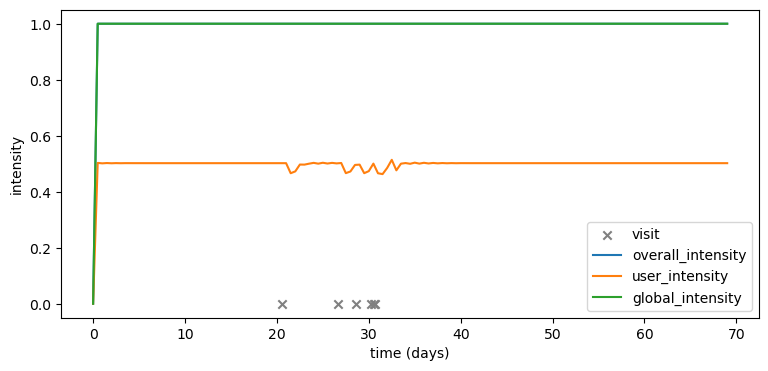

In [ ]:
# conditioned square continouous state + state_int new formulas
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, 
                dataset=dataloader.dataset, User_model = model, use_true_recommendations =True, 
                num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=conditioned, increment=.5)

total visits for user 6
overall_intensity:  tensor([[0.4791]]) 	user_intensity:  tensor([[0.4861]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4793]]) 	user_intensity:  tensor([[0.4862]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4425]]) 	user_intensity:  tensor([[0.4616]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4629]]) 	user_intensity:  tensor([[0.4753]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4884]]) 	user_intensity:  tensor([[0.4922]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


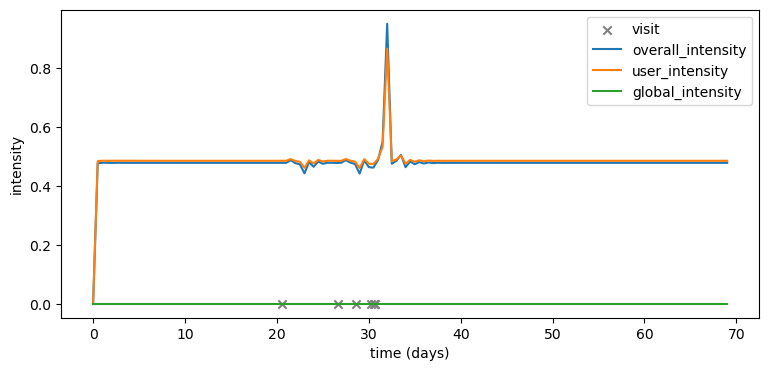

In [ ]:
# conditioned square continouous state + state_int
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=conditioned, increment=.5)

loaded sim_models
total visits for user 6
overall_intensity:  tensor([[0.4997]]) 	user_intensity:  tensor([[0.4998]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4988]]) 	user_intensity:  tensor([[0.4992]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4539]]) 	user_intensity:  tensor([[0.4692]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4550]]) 	user_intensity:  tensor([[0.4699]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4708]]) 	user_intensity:  tensor([[0.4805]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


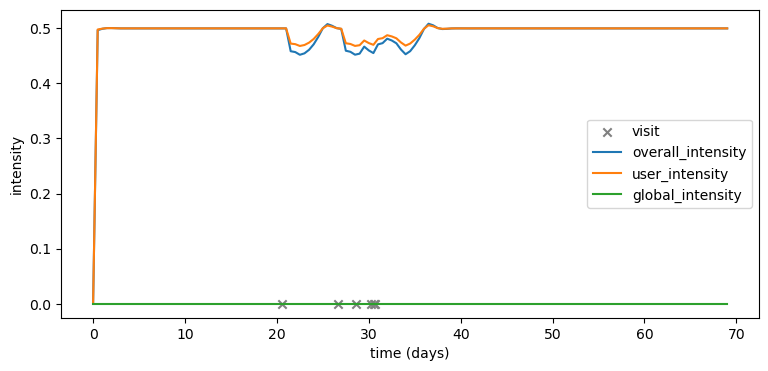

In [ ]:
# conditioned square continouous state
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=conditioned, increment=.5)

total visits for user 6
overall_intensity:  tensor([[0.4913]]) 	user_intensity:  tensor([[0.4942]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5027]]) 	user_intensity:  tensor([[0.5018]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5085]]) 	user_intensity:  tensor([[0.5056]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5214]]) 	user_intensity:  tensor([[0.5143]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5335]]) 	user_intensity:  tensor([[0.5223]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


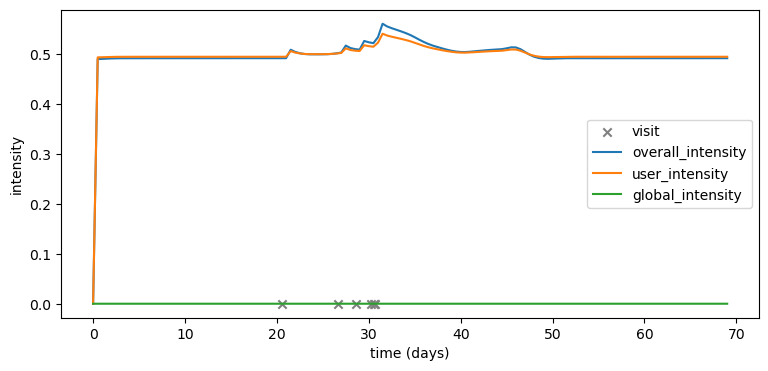

In [ ]:
# conditioned negative
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=conditioned, increment=.5)

total visits for user 7
overall_intensity:  tensor([[0.4873]]) 	user_intensity:  tensor([[0.4915]]) 	global_intensity:  tensor([4.8434e-29]) 	 before a recommendation.
overall_intensity:  tensor([[0.4734]]) 	user_intensity:  tensor([[0.4822]]) 	global_intensity:  tensor([4.7692e-39]) 	 before a recommendation.
overall_intensity:  tensor([[0.4891]]) 	user_intensity:  tensor([[0.4927]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4924]]) 	user_intensity:  tensor([[0.4950]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


overall_intensity:  tensor([[0.4925]]) 	user_intensity:  tensor([[0.4950]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4820]]) 	user_intensity:  tensor([[0.4880]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


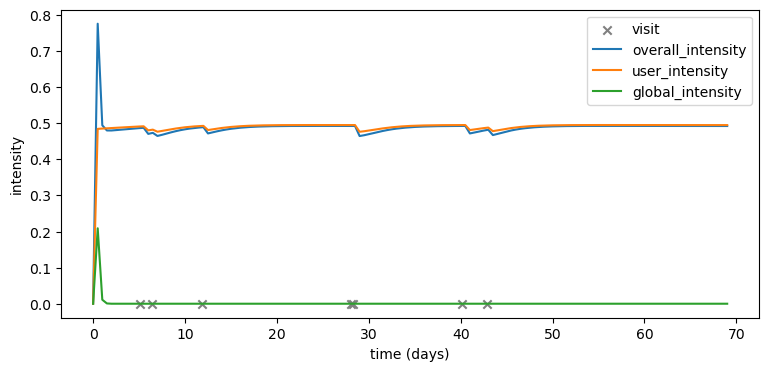

In [ ]:
# conditioned_square
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=4, conditioned=conditioned, increment=.5)

total visits for user 7
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5096]]) 	global_intensity:  tensor([1.0000]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.6996]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.6718]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.


/home/thahit/anaconda3/envs/WW/lib/python3.7/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5188]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5774]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.7162]]) 	global_intensity:  tensor([1.]) 	 before a recommendation.


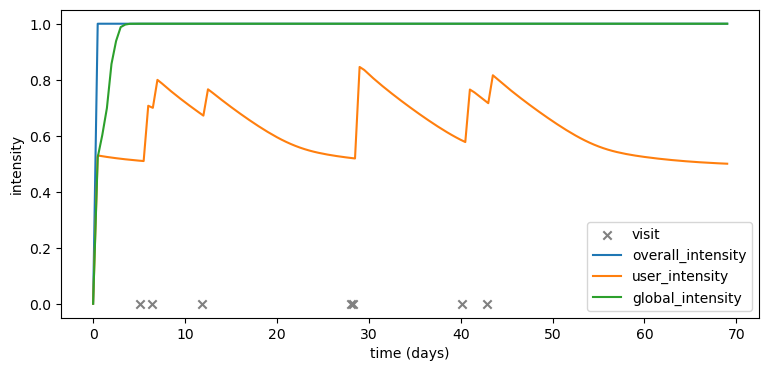

In [ ]:
# negative sampling  larger intervals
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=4, conditioned=False, increment=.5)

total visits for user 7
overall_intensity:  tensor([[0.4996]]) 	user_intensity:  tensor([[0.4997]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4962]]) 	user_intensity:  tensor([[0.4975]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5002]]) 	user_intensity:  tensor([[0.5001]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5002]]) 	user_intensity:  tensor([[0.5001]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4761]]) 	user_intensity:  tensor([[0.4841]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5002]]) 	user_intensity:  tensor([[0.5001]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4948]]) 	user_intensity:  tensor([[0.4965]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


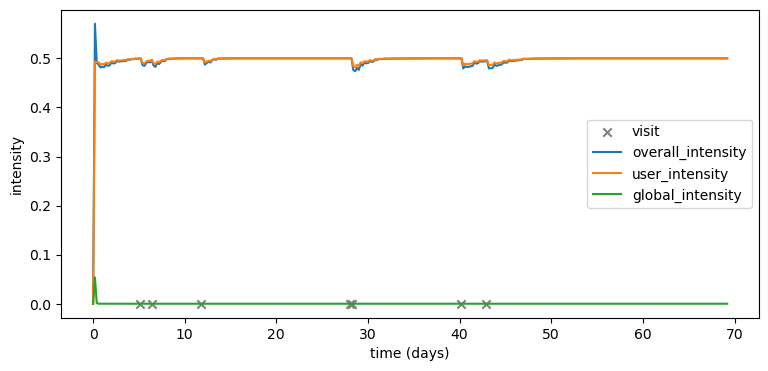

In [ ]:
# square  larger intervals train longer
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=4, conditioned=False, increment=.2)

loaded sim_models
total visits for user 12
overall_intensity:  tensor([[0.4660]]) 	user_intensity:  tensor([[0.4773]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.4668]]) 	user_intensity:  tensor([[0.4779]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.9060]]) 	user_intensity:  tensor([[0.8106]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.9868]]) 	user_intensity:  tensor([[0.9322]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[1.]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[1.]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[1.]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


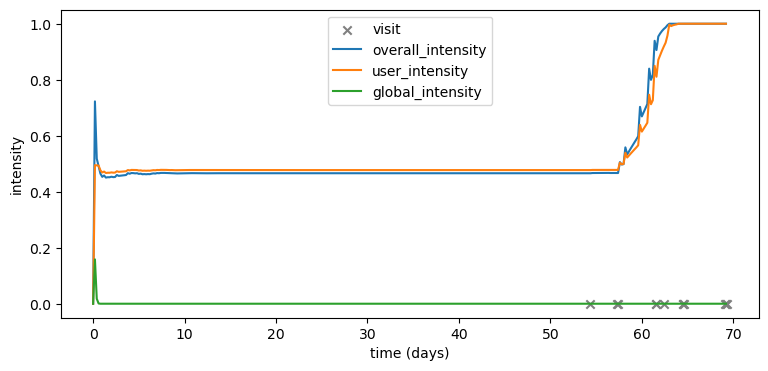

In [ ]:
# square  larger intervals
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=1, conditioned=False, increment=.2)

loaded sim_models
total visits for user 6
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([1.0000]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([1.0000]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([1.0000]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([1.0000]) 	 before a recommendation.
overall_intensity:  tensor([[1.0000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([1.0000]) 	 before a recommendation.


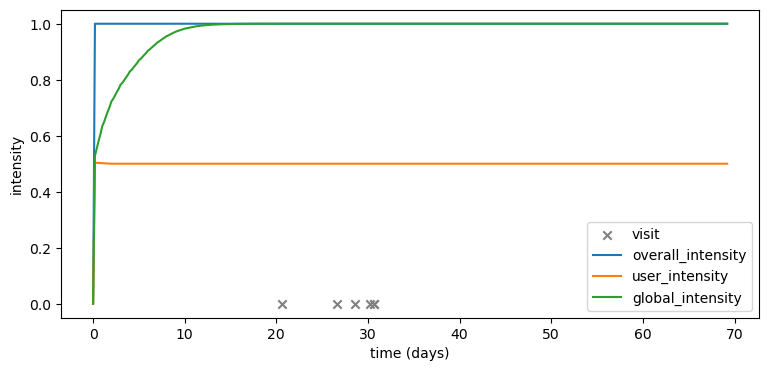

In [ ]:
# square continuous state integral
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=False)

loaded sim_models
total visits for user 6
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


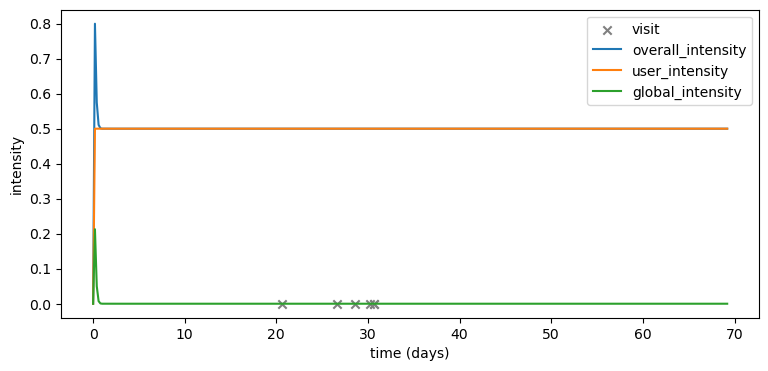

In [ ]:
# negative conditioned
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=True)

loaded sim_models
total visits for user 6
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


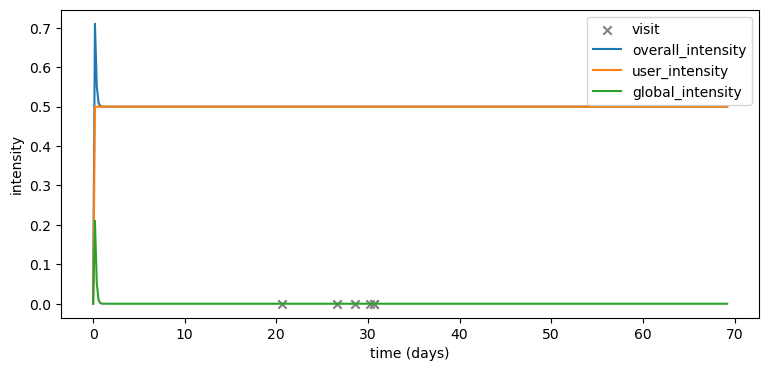

In [ ]:
# square conditioned
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2, conditioned=True)

loaded sim_models
total visits for user 6
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


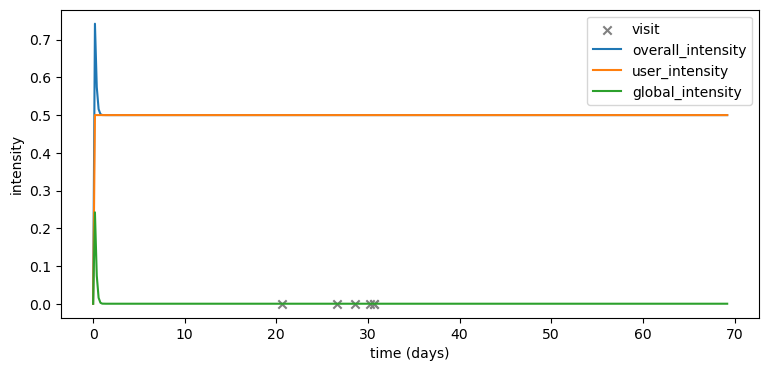

In [ ]:
# square
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=2)

total visits for user 12
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.
overall_intensity:  tensor([[0.5000]]) 	user_intensity:  tensor([[0.5000]]) 	global_intensity:  tensor([0.]) 	 before a recommendation.


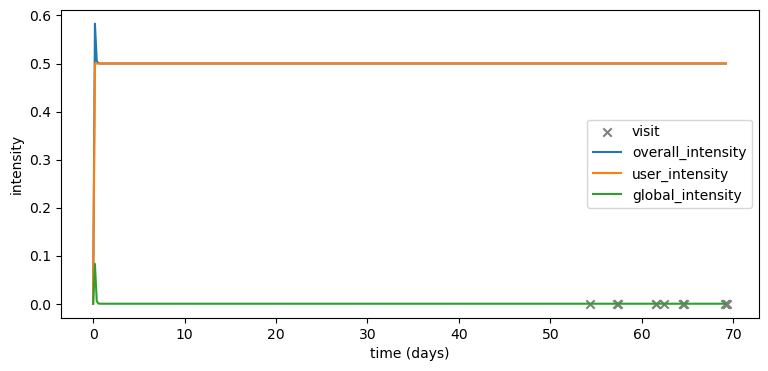

In [ ]:
#negative
explore_models.plot_rnd_user_visits_new(state_size, max_time=max_time, dataset=dataloader.dataset,
                    User_model = model, use_true_recommendations =True, num_classes = num_interaction_types,
                        teacher_forcing =True, user_idx=1)